<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Base" data-toc-modified-id="Data-Base-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Base</a></span></li><li><span><a href="#Main-classes" data-toc-modified-id="Main-classes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Main classes</a></span></li><li><span><a href="#Importing-External-File" data-toc-modified-id="Importing-External-File-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Importing External File</a></span><ul class="toc-item"><li><span><a href="#Loading-a-CSV-file" data-toc-modified-id="Loading-a-CSV-file-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Loading a CSV file</a></span></li><li><span><a href="#Creating-Db-object-from-a-Pandas-frame" data-toc-modified-id="Creating-Db-object-from-a-Pandas-frame-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Creating Db object from a Pandas frame</a></span></li><li><span><a href="#Creating-Db-object-directly-from-CSV-file" data-toc-modified-id="Creating-Db-object-directly-from-CSV-file-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Creating Db object directly from CSV file</a></span></li><li><span><a href="#Importing-Db-File-from-a-&quot;Neutral-File&quot;" data-toc-modified-id="Importing-Db-File-from-a-&quot;Neutral-File&quot;-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Importing Db File from a "Neutral File"</a></span></li></ul></li><li><span><a href="#Discovering-Db" data-toc-modified-id="Discovering-Db-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Discovering Db</a></span><ul class="toc-item"><li><span><a href="#The-Db-class" data-toc-modified-id="The-Db-class-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>The Db class</a></span></li><li><span><a href="#Assessors-for-Db-class" data-toc-modified-id="Assessors-for-Db-class-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Assessors for Db class</a></span></li><li><span><a href="#Locators" data-toc-modified-id="Locators-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Locators</a></span></li></ul></li><li><span><a href="#More-with-Db" data-toc-modified-id="More-with-Db-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>More with Db</a></span><ul class="toc-item"><li><span><a href="#Plotting-a-Db" data-toc-modified-id="Plotting-a-Db-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plotting a Db</a></span></li><li><span><a href="#Grid-Data-Base" data-toc-modified-id="Grid-Data-Base-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Grid Data Base</a></span></li><li><span><a href="#Selection" data-toc-modified-id="Selection-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Selection</a></span></li><li><span><a href="#Final-plot" data-toc-modified-id="Final-plot-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Final plot</a></span></li></ul></li></ul></div>

# Data Base

<!-- SUMMARY: Description of the Data Base (numerical). How to create a Db (from different sources), to use shortcuts (assessors), to assign roles to variables (locators).  -->

<!-- CATEGORY: Courses -->

In this preamble, we load the **gstlearn** package.

In [1]:
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import matplotlib.pyplot as plt
import numpy as np
import os

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

# Main classes

This is the (non-exhaustive) list of classes (of objects) in gstlearn:

* Db, DbGrid: numerical data base
* DirParam, VarioParam and Vario: experimental variograms
* Model: variogram model
* Neigh: neighborhood
* Anam: gaussian anamorphosis
* Polygon: 2-D polygonal shapes
* Rule: lithotype rule for thresholds used for truncated plurigaussian models

# Importing External File

## Loading a CSV file

We start by downloading the ASCII file called *Scotland_Temperatures.csv* (organized as a CSV file) and we store it in a temporary directory and keep its path in the variable called *temp_csv*. The file is provided as a *CSV* format. We load it into a Pandas data frame (names *datcsv*) using the relevant Python command. Note that "MISS" keyword is used in this file to indicate a missing value. Such values will be replaced by NaN.

In [2]:
temp_csv = gdoc.loadData("Scotland", "Scotland_Temperatures.csv")

In [3]:
import pandas as pd
datcsv = pd.read_csv(temp_csv, na_values="MISS")
datcsv

,Longitude,Latitude,Elevation,January_temp
0,372.1,658.9,255,1.7
1,303.5,665.9,125,2.0
2,218.4,597.9,8,4.6
3,245.0,955.0,90,NaN
4,326.8,691.2,32,3.1
...,...,...,...,...
231,273.2,564.6,47,2.8
232,333.9,730.1,30,2.6
233,185.0,655.0,115,NaN
234,259.8,587.9,119,2.1


We can check the contents of the data frame (by simply typing its name) and see that it contains four columns (respectively called *Longitude*, *Latitude*, *Elevation*, *January_temp*) and 236 rows (header line excluded).

## Creating Db object from a Pandas frame

The user can then create a database of the **gstlearn** package (*Db* class) directly from the previously imported Pandas frame. Note that the only numerical columns are copied.

In [4]:
dat = gl.Db_fromPanda(datcsv)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 0
Number of Columns            = 4
Total number of samples      = 236

Variables
---------
Column = 0 - Name = Longitude - Locator = NA
Column = 1 - Name = Latitude - Locator = NA
Column = 2 - Name = Elevation - Locator = NA
Column = 3 - Name = January_temp - Locator = NA

## Creating Db object directly from CSV file

These operations can be performed directly by reading the CSV file again and load it directly into a Db.

Note that we introduce a *CSVformat* description where we can specifiy the specificities of the file to be read, in particular we can tell how to spell the conventional value used for coding missing information.

In [5]:
csv = gl.CSVformat.create(flagHeader=True, naString = "MISS")
dat = gl.Db.createFromCSV(temp_csv, csv=csv)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 0
Number of Columns            = 5
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = NA
Column = 2 - Name = Latitude - Locator = NA
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = NA

Note that a "rank" variable has been automatically added. The *rank* is always 1-based and must be distinguish from an *index* (0-based). The *rank* variable could be later useful for certain functions of the **gstlearn** package.

## Importing Db File from a "Neutral File"

A last solution is to import it directly from the set of demonstration files (provided together with the package and called *temp_nf*) and stored in a specific format (Neutral file). 

These *NF* (or neutral file) are currently used for serialization of the gstlearn objects. They will probably be replaced in the future by a facility backuping the whole workspace in one step.

Note that the contents of the Db is slightly different from the result obtained when reading from CSV. Essentially, some variables have a *Locator* field defined, some do not. This concept will be described later in this chapter and the difference can be ignored.

In [6]:
temp_nf = gdoc.loadData("Scotland", "Scotland_Temperatures.NF")
dat = gl.Db.createFromNF(temp_nf)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1

# Discovering Db

## The Db class

*Db* objects (as all objects that inherits from *AStringable*) have a method `display` allowing to print a summary of the content of the data base. The same occurs when typing the name of the variable at the end of a cell (see above).

In [7]:
dat.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1
 

There, we can check that the 4 initial fields have been considered, in addition to a first one, automatically called *rank*, for a total of 5 columns (the information regarding *UID* will not be addressed in this chapter).

We can check that each field is assigned to a numbered *Column* (0-based index). Finally the total number of samples is 236 as expected.

In addition, some interesting information tells you that this data base corresponds to a 2-D dimension one: this will be described later together with the use of the *Locator* information.


To get more information on the contents of the Db, it is possible to use the *DbStringFormat* option and to use use through the *display* method. There are several ways to specify the type of information that is searched for (see the documentation of this class for details): typically here we ask for statistics but restrict them to a list of variables 

In [8]:
dbfmt = gl.DbStringFormat.createFromFlags(flag_stats=True, names=["Elevation", "January_temp"])
dat.display(dbfmt)


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 236

Data Base Statistics
--------------------
4 - Name Elevation - Locator NA
 Nb of data          =        236
 Nb of active values =        236
 Minimum value       =      2.000
 Maximum value       =    800.000
 Mean value          =    146.441
 Standard Deviation  =    165.138
 Variance            =  27270.713
5 - Name January_temp - Locator z1
 Nb of data          =        236
 Nb of active values =        151
 Minimum value       =      0.600
 Maximum value       =      5.200
 Mean value          =      2.815
 Standard Deviation  =      1.010
 Variance            =      1.020

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column =

Monovariate statistics are better displayed using a single function called *dbStatisticsMono*. This function waits for a vector of enumerators of type EStatOption as statistic operators. Such vector is created using a static function called *fromKeys* which is available in all enumerators classes (i.e. inherits from *AEnum*).

In [9]:
gl.dbStatisticsMono(dat,
                     names=["Elevation", "January_temp"],
                     opers=gl.EStatOption.fromKeys(["MEAN","MINI","MAXI"]))

                   Mean    Minimum    Maximum
   Elevation     87.974      3.000    387.000
January_temp      2.815      0.600      5.200

## Assessors for Db class

We can also consider the data base as a 2D array and use the *[  ]* assessors. The following usage shows the whole content of the data base dumped as a 2D **Numpy array**.

In [10]:
dat[:]

array([[  1. , 372.1, 658.9, 255. ,   1.7],
       [  2. , 303.5, 665.9, 125. ,   2. ],
       [  3. , 218.4, 597.9,   8. ,   4.6],
       ...,
       [234. , 185. , 655. , 115. ,   nan],
       [235. , 259.8, 587.9, 119. ,   2.1],
       [236. , 260.8, 668.6, 107. ,   2.6]])

We can access to one or several variables. Note that the contents of the Column corresponding to the target variable (i.e. *January_temp*) is produced as a 1D **numpy array**. 

Also note the presence of samples with *nan* corresponding to those where the target variable is not informed (*'MISS'* in the original dataset file).

In [11]:
dat["January_temp"]

array([1.7, 2. , 4.6, nan, 3.1, 3.5, 3.4, 3. , 4.9, 2.9, nan, 1.3, nan,
       4. , 1.7, nan, 1.9, 3.3, 2.3, nan, 2.3, 2.6, nan, 2.7, 2.9, nan,
       1. , 1.2, nan, 3.1, nan, 3.7, 2.1, 2.5, 2.9, nan, nan, nan, 3.1,
       2.1, nan, 2.7, 3. , nan, nan, 1.8, nan, nan, 2.2, 2.9, 3.3, nan,
       5. , 1.6, nan, 2.1, 3.2, 4.2, 1.1, nan, 2.7, 0.6, 3.2, nan, 2.5,
       2. , 2.8, nan, 3.2, 3.2, 4.5, 3.3, 4.1, 2.2, 1.7, 4.3, 5.2, nan,
       1.6, 3.9, 3.1, nan, 3.5, 4.7, 3.6, nan, 1.8, 1.7, nan, nan, nan,
       nan, nan, nan, nan, 1.7, nan, 3. , 4.6, 3.9, 3.2, 1.3, nan, nan,
       nan, 4.7, nan, 2.6, 2. , 4.7, 1.2, 2.9, 0.9, 3. , nan, 3.6, 0.7,
       3.3, nan, nan, nan, 2.7, nan, 2.7, 2.4, nan, nan, 2. , 2.6, nan,
       4.3, nan, nan, nan, nan, 3.1, 3.4, 3.1, 2. , 1.3, 1.9, nan, 3.3,
       2.7, 4.4, nan, 3. , 0.9, 0.7, nan, 3.6, nan, 3.5, nan, 2.4, 1. ,
       nan, 3.6, nan, nan, nan, nan, 3. , nan, 3.5, 4. , 3. , 3.6, nan,
       3.2, 1.7, 2.7, 1.9, nan, nan, 4.4, 1.9, 3.3, nan, nan, 3.

But it can be more restrictive as in the following paragraph, where we only consider the samples 10 to 15, and only consider the variables *rank*, *Latitude*, *Elevation*. Remind that indices start from 0 to N-1. Indices slice '10:15' in Python means indices {10,11,12,13,14} (different from R) which means ranks {11,12,13,14,15}.

In [12]:
dat[10:15, ["rank", "Latitude", "Elevation"]]

array([[ 11. , 865. ,  37. ],
       [ 12. , 602.6, 242. ],
       [ 13. , 835. , 295. ],
       [ 14. , 933.2,  15. ],
       [ 15. , 648.8, 183. ]])

We can also replace the variable *Name* by their *Column* index. Although this is not recommanded as the Column index may vary over time.

In [13]:
dat[10:15, 2:4]

array([[865. ,  37. ],
       [602.6, 242. ],
       [835. , 295. ],
       [933.2,  15. ],
       [648.8, 183. ]])

A particular function is available to convert all the data base in an appropriate object of the Target Langage (here Python). A gstlearn *Db* is converted into a *Pandas frame* using **toTL**.

In [14]:
dat.toTL()

,rank,Longitude,Latitude,Elevation,January_temp
0,1.0,372.1,658.9,255.0,1.7
1,2.0,303.5,665.9,125.0,2.0
2,3.0,218.4,597.9,8.0,4.6
3,4.0,245.0,955.0,90.0,NaN
4,5.0,326.8,691.2,32.0,3.1
...,...,...,...,...,...
231,232.0,273.2,564.6,47.0,2.8
232,233.0,333.9,730.1,30.0,2.6
233,234.0,185.0,655.0,115.0,NaN
234,235.0,259.8,587.9,119.0,2.1


Please also note the feature that a variable whose name does not exist (*newvar*) in the data base, is created on the fly. Also note that variables may be specified with names referred to using traditional regexp expressions (i.e. the symbol '*' replaces any list of characters):

In [15]:
dat["newvar"] = 12.3 * dat["Elevation"] - 2.1 * dat["*temp"]
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 6
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1
Column = 5 - Name = newvar - Locator = NA

The user also can remove a variable from the data base by doing the following:

In [16]:
dat.deleteColumn("newvar")
dat.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1
 

## Locators

The locators are used to specify the **role** assigned to a Column for the rest of the study (unless changed further). The *locator* is characterized by its name (*Z* for a variable and *X* for a coordinate) within the Enumerator *ELoc*.

In [17]:
dat.setLocators(["Longitude","Latitude"], gl.ELoc.X)
dat.setLocator("January_temp", gl.ELoc.Z)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1

As can be seen in the printout, variables *Latitude* and *Longitude* have been designated as coordinates (pay attention to the order) and *January_temp* is the (unique) variable of interest. Therefore any subsequent step will be performed as a monovariate 2-D process.

The locator is translated into a *letter*,*number* pair for better legibility: e.g. *x1* for the first coordinate.

Here are all the **roles** known by **gstlearn**:

In [18]:
gl.ELoc.printAll()

  -1 -     UNKNOWN : Unknown locator
    0 -           X : Coordinate
    1 -           Z : Variable
    2 -           V : Variance of measurement error
    3 -           F : External Drift
    4 -           G : Gradient component
    5 -           L : Lower bound of an inequality
    6 -           U : Upper bound of an inequality
    7 -           P : Proportion
    8 -           W : Weight
    9 -           C : Code
   10 -         SEL : Selection
   11 -         DOM : Domain
   12 -        BLEX : Block Extension
   13 -        ADIR : Dip direction Angle
   14 -        ADIP : Dip Angle
   15 -        SIZE : Object height
   16 -          BU : Fault UP termination
   17 -          BD : Fault DOWN termination
   18 -        TIME : Time variable
   19 -       LAYER : Layer rank
   20 -      NOSTAT : Non-stationary parameter
   21 -        TGTE : Tangent
   22 -        SIMU : Conditional or non-conditional simulations
   23 -      FACIES : Facies simulated
   24 -     GAUSFAC : Gaussian 

# More with Db

## Plotting a Db

Plot the contents of a Db using functions of the **gstlearn.plot** sub-package (which relies on **matplotlib**). The color option (**nameColor**) is used to represent the **january_temp** variable.

Note: Non availalble values (NaN) are converted into 0 for display purpose. This behavior will be modified and tunable in future versions.

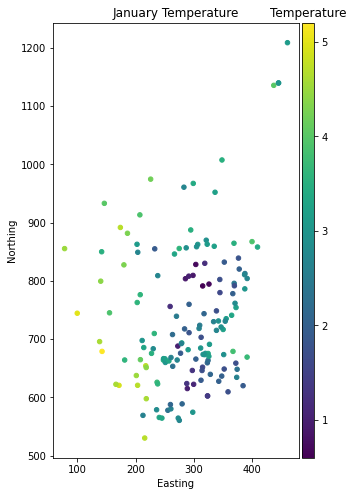

In [19]:
fig, ax = gp.initGeographic()
ax.symbol(dat, nameColor="January_temp", flagLegendColor=True, legendNameColor="Temperature")
ax.decoration(title="January Temperature", xlabel="Easting", ylabel="Northing")
plt.show()

A more elaborated graphic representation displays the samples with a symbol proportional to the Elevation (**nameSize**) and a color representing the Temperature (**nameColor**).

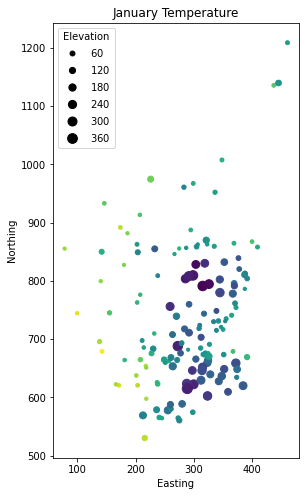

In [20]:
fig, ax = gp.initGeographic()
ax.symbol(dat, nameSize="Elevation", nameColor="*temp", flagLegendSize=True, legendNameSize="Elevation")
ax.decoration(title="January Temperature", xlabel="Easting", ylabel="Northing")
plt.show()

Of course, you can use your own graphical routines (for example, a direct call to **matplotlib**) by simply accessing to the *gstlearn* data base values (using '[ ]' accessor):

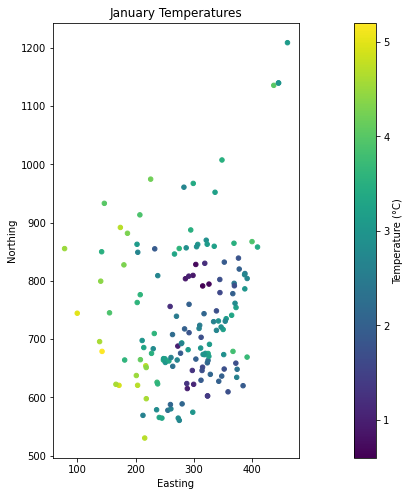

In [21]:
plt.figure(figsize=(20,8))
plt.scatter(dat["x1"], dat["x2"], s=20, c=dat["*temp"]) # Locator or variable name is OK
plt.title("January Temperatures")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.colorbar(label="Temperature (°C)")
plt.gca().set_aspect('equal') # Respect aspect ratio
plt.show()

## Grid Data Base

On the same area, a terrain model is available (as a demonstration file available in the package distribution). We first download it and create the corresponding data base defined on a grid support (*DbGrid*).

In [22]:
elev_nf = gdoc.loadData("Scotland", "Scotland_Elevations.NF")
grid = gl.DbGrid.createFromNF(elev_nf)
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Total number of samples      = 11097
Number of active samples     = 3092

Grid characteristics:
---------------------
Origin :     65.000   535.000
Mesh   :      4.938     4.963
Number :         81       137

Variables
---------
Column = 0 - Name = Longitude - Locator = x1
Column = 1 - Name = Latitude - Locator = x2
Column = 2 - Name = Elevation - Locator = f1
Column = 3 - Name = inshore - Locator = sel

We can check that the grid is constituted of 81 columns and 137 rows, or 11097 grid cells. We can also notice that some locators are already defined (these information are stored in the Neutral File).


## Selection

We can check the presence of a variable (called *inshore*) which is assigned to the *sel* locator: this corresponds to a *Selection* which acts as a binary filter: some grid cells are active and others are masked off. The count of active samples is given in the previous printout (3092). This selection remains active until the locator 'sel' is replaced or deleted (there may not be more than one selection defined at a time per data base). This is what can be seen in the following display where the *Elevation* is automatically represented **only** within the *inshore* selection.

Note that any variable (having values equal to 0/1 or True/False) can be considered as a Selection: it must simply be assigned to the *sel* locator using the *setLocator* method described earlier.

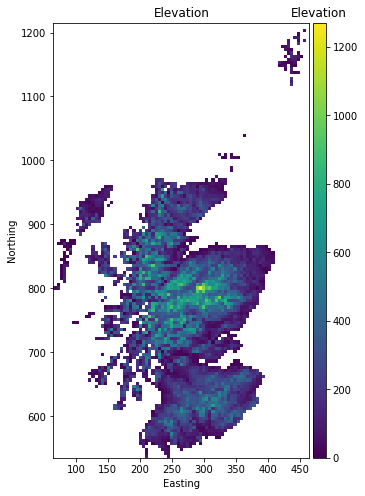

In [23]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Elevation", flagLegend=True)
ax.decoration(title="Elevation", xlabel="Easting", ylabel="Northing")
plt.show()

## Final plot

On this final plot, we combine grid and point representations.

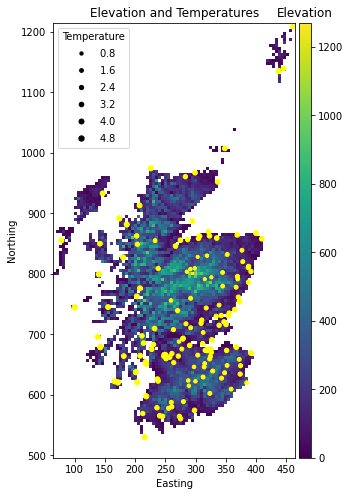

In [24]:
fig, ax = gp.initGeographic()
ax.raster(grid, name="Elevation", flagLegend=True)
ax.symbol(dat, nameSize="*temp", flagLegendSize=True, legendNameSize="Temperature", sizmin=10, sizmax=30, c="yellow")
ax.decoration(title="Elevation and Temperatures", xlabel="Easting", ylabel="Northing")
plt.show()